# Training 1/3 resolution models (318px)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import rioxarray
import rasterio
import re
import random
import matplotlib.patches as patches
from tqdm import tqdm

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.train_test_val_splitting import *
from levee_hunter.modeling.train import train_model
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.modeling.metrics import get_pred_mask, plot_skeletons, custom_metrics, standard_metrics
from levee_hunter.plotting import plot, plot_training_validation_loss
from levee_hunter.modeling.inference import infer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold, GroupKFold

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss


/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

### Creating Dataset

In [2]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

### Training Model

In [3]:
# Define a combined loss function that uses both BCE and Dice loss
class DiceBCELoss(nn.Module):
   def __init__(self, bce_weight=0.5, dice_weight=0.5, mode='binary'):
      super(DiceBCELoss, self).__init__()
      self.bce_weight = bce_weight
      self.dice_weight = dice_weight
      self.bce = nn.BCEWithLogitsLoss()
      self.dice = DiceLoss(mode=mode)
      
   def forward(self, y_pred, y_true):
      bce_loss = self.bce(y_pred, y_true)
      dice_loss = self.dice(y_pred, y_true)
      return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
def dice_s(prediction, target, threshold=0.5):
    pred = torch.sigmoid(prediction).cpu().numpy()
    pred = (pred > threshold).astype(np.uint8)
    target = target.cpu().numpy()
    
    intersection = np.sum(pred * target)
    return 2 * intersection / (np.sum(pred) + np.sum(target) + 1e-6)

def iou_s(prediction, target, threshold=0.5):
    pred = torch.sigmoid(prediction).cpu().numpy()
    pred = (pred > threshold).astype(np.uint8)
    target = target.cpu().numpy()
    
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return intersection / (union + 1e-6)

In [7]:
# Groups based on filenames
# Extract group IDs from the file paths - keeping everything before "_pX_wY"
groups = []
for path in dataset.img_paths:
   # Convert path to string if it's a Path object
   path_str = str(path)
   # Extract the base pattern without "_pX_wY.tif"
   match = re.search(r'(.+)_p\d+_w\d+\.tif$', path_str)
   if match:
      group_id = match.group(1)
      groups.append(group_id)
   else:
      # Fallback if pattern doesn't match
      groups.append(path_str)

print(f"Total images: {len(groups)}")
print(f"Unique groups: {len(set(groups))}")

unique_groups = list(set(groups))
random.shuffle(unique_groups)
group_to_idx = {g: i for i, g in enumerate(unique_groups)}
group_ids = [group_to_idx[g] for g in groups]

Total images: 1316
Unique groups: 44


In [9]:
# Number of folds for cross-validation
num_folds = 5

# Create a GroupKFold instead of regular KFold
kfold = GroupKFold(n_splits=num_folds)

# Lists to store metrics for each fold
fold_results = []
all_train_losses = []
all_val_losses = []
per_image_results = []  # To store per-image results

# Create a list of all dataset indices
dataset_size = len(dataset)
indices = list(range(dataset_size))

batch_size = 16

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices, groups=group_ids)):
   print(f"Starting fold {fold+1}/{num_folds}")
   
   # Create train and validation subdatasets
   train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
   val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
   
   # Define data loaders for this fold
   fold_train_loader = DataLoader(
      dataset, 
      batch_size=batch_size, 
      sampler=train_subsampler,
      shuffle=False
   )
   
   fold_val_loader = DataLoader(
      dataset,
      batch_size=batch_size,
      sampler=val_subsampler,
      shuffle=False
   )
   
   # Reset model for each fold
   model = smp.UnetPlusPlus(
      encoder_name="resnet50", 
      encoder_weights="imagenet", 
      in_channels=1, 
      classes=1
   ).to(device)
   
   optimizer = optim.Adam(model.parameters(), lr=1e-4)

   # Define model name with fold number to save each fold's model separately
   model_path = f"../models/Unet-13_384_invert_fold{fold+1}.pth"

   model, train_losses, val_losses = train_model(
      model=model,
      train_loader=fold_train_loader,
      test_loader=fold_val_loader,
      optimizer=optimizer,
      criterion=DiceBCELoss(),
      epochs=5,
      save_model='best',
      save_model_path=model_path,
   )
   
   # Save the losses
   all_train_losses.append(train_losses)
   all_val_losses.append(val_losses)
   
   # Evaluate the model
   model.eval()
   preds, targets = get_preds_targets(model=model, val_loader=fold_val_loader, device=device)

   # Get the actual image indices from the validation sampler
   # We need to map back to the original dataset indices
   val_indices = [val_idx[i] for i in range(len(preds))]
   # Get file names for the validation images
   val_filenames = [dataset.img_paths[idx] for idx in val_indices]
   
   image_metrics = []
   for i in tqdm(range(len(preds)), desc="Processing images"):
      pred = preds[i]
      target = targets[i]
      
      # Calculate metrics for this image
      dice = dice_s(target, pred, threshold=0.5)
      iou = iou_s(target, pred, threshold=0.5)
      
      image_metrics.append({
         'dice': dice,
         'iou': iou,
         'filename': val_filenames[i]
      })
   
   # Convert to DataFrame
   fold_per_image_results = pd.DataFrame(image_metrics)
   fold_per_image_results['fold'] = fold+1
   per_image_results.append(fold_per_image_results)
   

   # Calculate overall metrics
   print("Calculating overall metrics for this fold...")
   avg_dice = np.mean([m['dice'] for m in image_metrics])
   avg_iou = np.mean([m['iou'] for m in image_metrics])
   
   # Create metrics dictionary for this fold
   fold_metrics = {
      'fold': fold + 1,
      'dice': avg_dice,
      'iou': avg_iou,
      'val_loss': val_losses[-1]  # Final validation loss
   }
   
   # Append to results list
   fold_results.append(fold_metrics)
   
   print(f"Fold {fold+1} metrics: Dice={avg_dice:.4f}, IoU={avg_iou:.4f}, Val Loss={val_losses[-1]:.4f}")

Starting fold 1/5
beginning training on device: cuda
Epoch: 1/5 Train Loss: 0.678759 Test Loss: 0.041075
Train Levee Loss: 0.678300 (811.0) Train Non-Levee Loss: 0.680801 (242.0)
Test Levee Loss: 0.635500 (208.0) Test Non-Levee Loss: 0.635409 (55.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Epoch: 2/5 Train Loss: 0.615026 Test Loss: 0.038356
Train Levee Loss: 0.615223 (811.0) Train Non-Levee Loss: 0.614583 (242.0)
Test Levee Loss: 0.593270 (208.0) Test Non-Levee Loss: 0.593302 (55.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Epoch: 3/5 Train Loss: 0.584413 Test Loss: 0.036849
Train Levee Loss: 0.584583 (811.0) Train Non-Levee Loss: 0.584015 (242.0)
Test Levee Loss: 0.569987 (208.0) Test Non-Levee Loss: 0.570100 (55.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Epoch: 4/5 Train Loss: 0.561462 Test Loss: 0.035612
Train Levee Loss: 0.561504 (811.0) Train Non-Levee Loss: 0.561429 (242.0)
Test Levee Loss: 0.550788 

Processing images: 100%|██████████| 263/263 [00:00<00:00, 399.10it/s]


Calculating overall metrics for this fold...
Fold 1 metrics: Dice=0.9985, IoU=0.9969, Val Loss=0.0345
Starting fold 2/5
beginning training on device: cuda
Epoch: 1/5 Train Loss: 0.575269 Test Loss: 0.035600
Train Levee Loss: 0.574849 (814.0) Train Non-Levee Loss: 0.577177 (238.0)
Test Levee Loss: 0.552904 (205.0) Test Non-Levee Loss: 0.552513 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Epoch: 2/5 Train Loss: 0.535940 Test Loss: 0.034162
Train Levee Loss: 0.535874 (814.0) Train Non-Levee Loss: 0.536499 (238.0)
Test Levee Loss: 0.530385 (205.0) Test Non-Levee Loss: 0.530836 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Epoch: 3/5 Train Loss: 0.516784 Test Loss: 0.032954
Train Levee Loss: 0.516648 (814.0) Train Non-Levee Loss: 0.517245 (238.0)
Test Levee Loss: 0.512110 (205.0) Test Non-Levee Loss: 0.511335 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Epoch: 4/5 Train Loss: 0.497907 Test Loss: 0.03183

Processing images: 100%|██████████| 264/264 [00:00<00:00, 565.32it/s]


Calculating overall metrics for this fold...
Fold 2 metrics: Dice=0.9978, IoU=0.9955, Val Loss=0.0303
Starting fold 3/5
beginning training on device: cuda
Epoch: 1/5 Train Loss: 0.784255 Test Loss: 0.045408
Train Levee Loss: 0.786150 (823.0) Train Non-Levee Loss: 0.778449 (230.0)
Test Levee Loss: 0.702090 (196.0) Test Non-Levee Loss: 0.703906 (67.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Epoch: 2/5 Train Loss: 0.684880 Test Loss: 0.042563
Train Levee Loss: 0.685162 (823.0) Train Non-Levee Loss: 0.684098 (230.0)
Test Levee Loss: 0.658611 (196.0) Test Non-Levee Loss: 0.659505 (67.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Epoch: 3/5 Train Loss: 0.644438 Test Loss: 0.040531
Train Levee Loss: 0.644517 (823.0) Train Non-Levee Loss: 0.644359 (230.0)
Test Levee Loss: 0.627188 (196.0) Test Non-Levee Loss: 0.628940 (67.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Epoch: 4/5 Train Loss: 0.617460 Test Loss: 0.03907

Processing images: 100%|██████████| 263/263 [00:00<00:00, 412.68it/s]


Calculating overall metrics for this fold...
Fold 3 metrics: Dice=0.9985, IoU=0.9971, Val Loss=0.0381
Starting fold 4/5
beginning training on device: cuda
Epoch: 1/5 Train Loss: 0.589555 Test Loss: 0.036146
Train Levee Loss: 0.589451 (813.0) Train Non-Levee Loss: 0.590252 (240.0)
Test Levee Loss: 0.559354 (206.0) Test Non-Levee Loss: 0.559030 (57.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Epoch: 2/5 Train Loss: 0.550833 Test Loss: 0.035302
Train Levee Loss: 0.551226 (813.0) Train Non-Levee Loss: 0.549623 (240.0)
Test Levee Loss: 0.546364 (206.0) Test Non-Levee Loss: 0.546484 (57.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Epoch: 3/5 Train Loss: 0.531067 Test Loss: 0.033923
Train Levee Loss: 0.530935 (813.0) Train Non-Levee Loss: 0.531608 (240.0)
Test Levee Loss: 0.524713 (206.0) Test Non-Levee Loss: 0.525221 (57.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Epoch: 4/5 Train Loss: 0.512608 Test Loss: 0.03264

Processing images: 100%|██████████| 263/263 [00:00<00:00, 452.42it/s]


Calculating overall metrics for this fold...
Fold 4 metrics: Dice=0.9971, IoU=0.9942, Val Loss=0.0312
Starting fold 5/5
beginning training on device: cuda
Epoch: 1/5 Train Loss: 0.743662 Test Loss: 0.043861
Train Levee Loss: 0.743217 (815.0) Train Non-Levee Loss: 0.745981 (238.0)
Test Levee Loss: 0.678226 (204.0) Test Non-Levee Loss: 0.678695 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Epoch: 2/5 Train Loss: 0.648332 Test Loss: 0.040051
Train Levee Loss: 0.648487 (815.0) Train Non-Levee Loss: 0.648115 (238.0)
Test Levee Loss: 0.619555 (204.0) Test Non-Levee Loss: 0.619877 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Epoch: 3/5 Train Loss: 0.608081 Test Loss: 0.038331
Train Levee Loss: 0.608006 (815.0) Train Non-Levee Loss: 0.608524 (238.0)
Test Levee Loss: 0.592941 (204.0) Test Non-Levee Loss: 0.593016 (59.0)
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Epoch: 4/5 Train Loss: 0.581139 Test Loss: 0.03678

Processing images: 100%|██████████| 263/263 [00:00<00:00, 385.58it/s]

Calculating overall metrics for this fold...
Fold 5 metrics: Dice=0.9986, IoU=0.9972, Val Loss=0.0358


### Results

In [10]:
# Combine per-image results across all folds
all_per_image_results = pd.concat(per_image_results, ignore_index=True)

# Summarize results across folds
df_results = pd.DataFrame(fold_results)
print("K-fold Cross Validation Results:")
print(df_results)
print("\nMean results across all folds:")
print(df_results.drop('fold', axis=1).mean())

K-fold Cross Validation Results:
   fold      dice       iou  val_loss
0     1  0.998461  0.996931  0.034463
1     2  0.997765  0.995549  0.030325
2     3  0.998536  0.997082  0.038109
3     4  0.997074  0.994185  0.031241
4     5  0.998578  0.997164  0.035840

Mean results across all folds:
dice        0.998083
iou         0.996182
val_loss    0.033996
dtype: float64


### Challenging Images

In [11]:
# Group by original image index and find consistently problematic images
# Calculate mean and std of dice scores for each image across folds
problem_images = all_per_image_results.groupby('filename').agg({
   'dice': ['mean', 'count']
})

# Flatten the multi-index columns
problem_images.columns = ['_'.join(col).strip() for col in problem_images.columns.values]

# Sort by mean dice score (ascending) to find the most problematic images
problem_images_sorted = problem_images.sort_values('dice_mean')

print("\nTop 10 most challenging images (lowest average Dice score):")
print(problem_images_sorted.head(25))


Top 10 most challenging images (lowest average Dice score):
                                                    dice_mean  dice_count
filename                                                                 
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.986491           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.986880           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.987141           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.987521           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988204           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988621           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988796           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988815           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988886           1
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.988896           1
/share/gpu5/ucapmgb/levee-hunter/data/processed... 

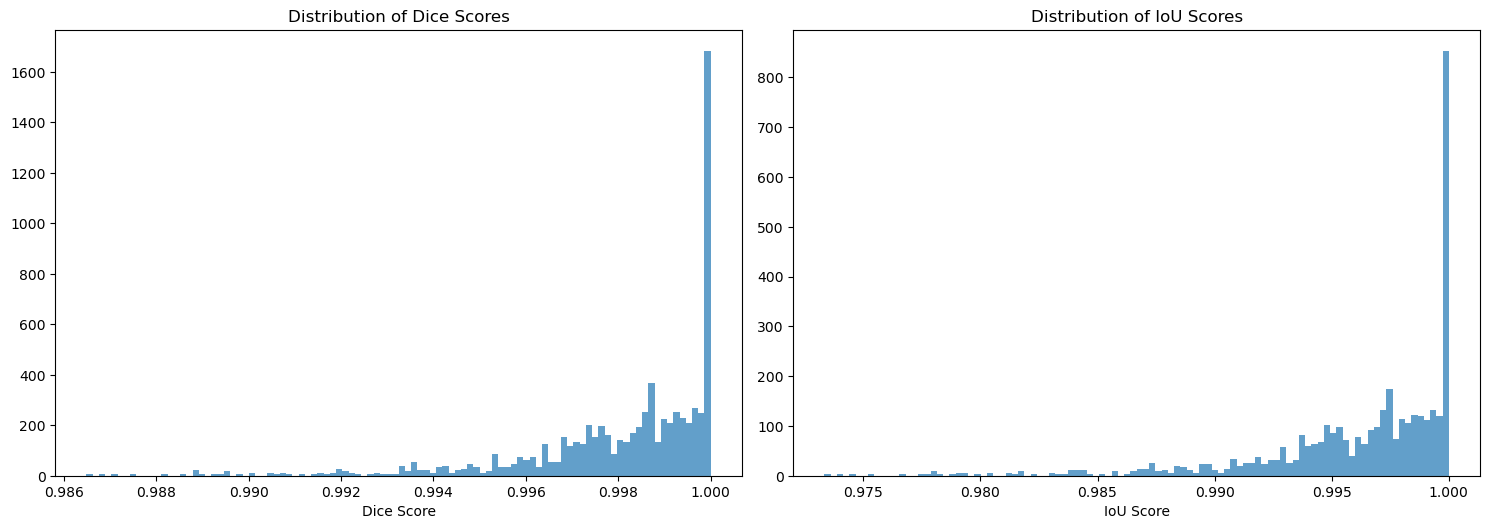

In [12]:
# Visualize per-image metric distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(all_per_image_results['dice'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of Dice Scores')
plt.xlabel('Dice Score')

plt.subplot(2, 2, 2)
plt.hist(all_per_image_results['iou'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')

plt.tight_layout()
plt.show()